
# TERM PAPER TECH2 Fall, 2025

Candidate number:
- 	36
-   44
-   66





### Libraries used


In [578]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
# styling 
from matplotlib.colors import TABLEAU_COLORS

## Part 1 — Reading in the data


### 1.1 - Importing CSV files and structure them in DataFrame

#### Function to create path strings for CSV files

In [579]:
def create_file_paths(folderLocation, startYear, endYear):
    """
    Creates a list of CSV file paths based on the specified folder location and year range.

    Parameters:
    folderLocation (str): The directory where the CSV files are stored.
    startYear (int): The starting year for the data.
    endYear (int): The ending year for the data.

    Returns:
    list: A list of file paths for the CSV files.
    """

    months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
    CSV_files = []

    # iterate through months and years to construct file paths
    for month in months:
        for year in range(startYear, endYear + 1):

            # creating file structure 
            csv_string = f"{folderLocation}/SCE-{month}-{year}.csv" 
            CSV_files.append(csv_string)

    return  CSV_files



#### Function to import and merge multiple CSV files


In [580]:
def importCSV(files, sep=";", ):
    """
    Imports multiple CSV files and concatenates them into a single DataFrame.

    Parameters:
    files (list): A list of file paths for the CSV files.
    sep (str): The delimiter used in the CSV files. Default is ';'.

    Returns:
    pd.DataFrame: A concatenated DataFrame containing data from all CSV files.
    """

    all_dfs = []

    for file in files:
        try:
            df = pd.read_csv(file, sep=sep)
            all_dfs.append(df)
        except FileNotFoundError:
            print(f"File not found: {file}")
            continue
    
    # Check if any DataFrames were loaded
    if not all_dfs:
        raise ValueError("No valid CSV files found.")

    # Concatenate all DataFrames and resetting index
    return pd.concat(all_dfs, ignore_index=True)

#### Importing CSV files and structure them in DataFrames

In [581]:
# importing data and creating dataframe
CSV_files = create_file_paths("data", 2014, 2024)
df = importCSV(CSV_files)

cpi = pd.read_csv("data/CPI.csv")

### 1.2 - Report of the SCE DataFrame statistics

#### Function to display statistics  

In [582]:
def df_stats(df):
    """
    Function to print basic statistics about the dataframe 
    """
    unique_persons = df["userid"].nunique()

    print(f"Unique persons: {unique_persons}")
    print(f"Number of rows: {df.shape[0]}")

    print(f"Number of unique survey waves: {df['wid'].nunique()}")

    earliest_date = df['date'].min()
    print(f"Earliest date: {earliest_date}")

    latest_date = df['date'].max()
    print(f"Latest date: {latest_date}")


#### Displaying the statistics of the imported DataFrame

In [583]:
df_stats(df)

Unique persons: 21666
Number of rows: 165924
Number of unique survey waves: 132
Earliest date: 2014-01-02
Latest date: 2024-12-31


## Part 2  — Data pre-processing

### 2.1 - Filling missing numeracy variables

#### Function to Forward-fill missing numeracy values using each user's first observed entry


In [ ]:
def forward_fill_numeracy(df, col_names):
    """
    Forward-fills numeracy columns (specified in col_names) per individual
    using the first observed value for each user.

    Parameters:
    - df: DataFrame containing the data.
    - col_names: List of column names to forward-fill.

    returns:
    - DataFrame with forward-filled numeracy columns.

    If None, no columns are forward-filled.
    """

    # Check if col_names is provided
    if not col_names:
        print("No changes were made as no numeracy columns were found.")
        return df

    # Forward-fill the specified columns and return the updated DataFrame
    first_vals = df.groupby("userid", dropna=False)[col_names].transform("first")
    df[col_names] = df[col_names].fillna(first_vals)
    return df

#### Forward-fill NaN-values for numeracy variables

In [585]:
num_cols = []

for c in df.columns:
    if c.endswith("_correct") and c.startswith("num_lit_"):
        num_cols.append(c)

df = forward_filled_df = forward_fill_numeracy(df, num_cols)



### 2.2 - Drop observations


#### Function to drops rows with missing values (NaN) in the specified required columns

In [586]:

def filter_rows(df, required_cols):
    """
    Drops rows with missing values (NaN) in the specified required columns.

    Parameters:
    - df: DataFrame containing the data.
    - required_cols: List of column names that are required.

    returns:
    - DataFrame with rows containing missing values in required columns dropped.
    """
    initial_len = len(df)
    df = df.dropna(subset=required_cols)
    dropped_rows = initial_len - len(df)
    return df, dropped_rows



#### Removes every row that contains Nan elements in specified required columns.

In [587]:
# Define required columns for each section
required_cols = ["female", "age", "educ", "inflation", "house_price_change", "prob_stocks_up"] + num_cols


df, dropped_rows = filter_rows(df, required_cols)
print(f"\nDropped rows with missing required values: {dropped_rows:,}")


Dropped rows with missing required values: 28,348


### 2.3 - Function to drop outliers

In [588]:
def remove_outliers(df, col_names, lower_pct, upper_pct, verbose=False): 
    """
    Removes outliers from specified columns in the DataFrame based on given lower and upper percentiles
    
    Parameters:
    - df: DataFrame containing the data.
    - col_names: List of column names to check for outliers.
    - lower_pct: Lower percentile threshold to drop outliers.
    - upper_pct: Upper percentile threshold to drop outliers.
    
    returns:
    - DataFrame with outliers removed.
    - total_dropped_outliers: Total number of outliers dropped across all specified columns."""
    total_dropped_outliers = 0

    for col in col_names:

        # calculate quantiles
        q_low = df[col].quantile(lower_pct)
        q_high = df[col].quantile(upper_pct)

        # create mask for values within the quantile range
        mask_keep = (q_low <= df[col]) & (df[col] <= q_high)


        dropped = (~mask_keep).sum()
        df = df.loc[mask_keep].copy()
        total_dropped_outliers += int(dropped)


        # makes it optional to print out the number of dropped outliers per column
        if verbose:

            print(f"Dropped outliers for {col}: {int(dropped):,}")



    return df, total_dropped_outliers






It removes outliers from each column in pct_col_names using the 0.1th and 99.9th percentiles.
Prints the number of rows removed per column and returns a DataFrame with outliers excluded.

In [589]:
# Remove outliers from expectation columns
pct_col_names = ["inflation", "house_price_change", "prob_stocks_up"]

df, total_dropped_outliers = remove_outliers(df, pct_col_names, 0.001, 0.999, verbose=True)

print(f"Total outliers dropped: {total_dropped_outliers:,}")


Dropped outliers for inflation: 119
Dropped outliers for house_price_change: 179
Dropped outliers for prob_stocks_up: 0
Total outliers dropped: 298


### 2.4 - Creating a binary indicator for college certificate

#### Function to create new binary column indicator 

In [590]:

def add_threshold_flag(df, col_name, new_col_name, threshold):
    """
    Adds a binary column to the DataFrame indicating whether the values in col_name exceed the threshold.

    Parameters:
    - df: DataFrame containing the data.
    - col_name: The name of the column to evaluate.
    - new_col_name: The name of the new binary column to create.
    - threshold: The threshold value for comparison.

    returns:
    - DataFrame with the new binary column added.
    """
    if col_name in df.columns:
        df[new_col_name] = (df[col_name] > threshold).astype(int)

    return df




#### Creating threshold flag for every person with at least a bachelor’s degree 

In [ ]:
# 4 = Bachelor’s degree or higher
df = add_threshold_flag(df, "educ", "college", 3)

### 2.5 – Count correct numeracy answers and classify respondents by numeracy level


#### Function to calculate total correct numeracy answers per respondent

In [ ]:

def num_correct_stats(df, arr_cols_name):
    """
    Calculates total correct numeracy answers per respondent,
    prints distribution of scores, and creates 'num_lit_high'.
    Returns the updated DataFrame and the median number of correct answers.

    Parameters:
    - df: DataFrame containing the data.
    - arr_cols_name: List of numeracy column names to sum.

    Returns:
    - DataFrame with 'num_correct' column added.
    """
    if not arr_cols_name:
        return df

    # Only run if numeracy columns exist
    # Sum correct answers per row
    df["num_correct"] = df[arr_cols_name].sum(axis=1)

    # Use only one observation per user to compute distribution
    df_unique = df.drop_duplicates(subset='userid').copy()
    unique_users = df_unique.shape[0]

    # Print percentage for each possible score
    counts = df_unique["num_correct"].value_counts().sort_index()
    for score, count in counts.items():
        percent = count / unique_users
        print(f"{percent:.2%} have {score} correct answers")


    return df

#### Calculating numeracy scores and flag individuals above the median


In [593]:
# Sum correct numeracy answers per row and create 'num_lit_high'
df= num_correct_stats(df, num_cols)
med = df["num_correct"].median()
df = add_threshold_flag(df, "num_correct", "num_lit_high", med)

0.14% have 0.0 correct answers
0.73% have 1.0 correct answers
2.40% have 2.0 correct answers
5.71% have 3.0 correct answers
10.51% have 4.0 correct answers
16.94% have 5.0 correct answers
27.41% have 6.0 correct answers
36.17% have 7.0 correct answers


### 2.6 - Report sample statistics

In [594]:
# Final sample stats
df_stats(df)

Unique persons: 17701
Number of rows: 137278
Number of unique survey waves: 117
Earliest date: 2015-04-02
Latest date: 2024-12-31


## Part 3 — Average expectations by group



### 3.0 - Establish functions to calculate results

#### Function to calculate the mean for given columns

In [595]:
def group_means(df, group_cols): 
    """
    Computes the mean of expectations variables for each group defined by GroupCol.

    Parameters:
    - df: DataFrame containing the data.
    - GroupCol: Column name to group by (e.g., 'female', 'college', 'num_lit_high').

    Returns:
    - DataFrame indexed by GroupCol, with mean values for 'inflation', 'house_price_change', and 'prob_stocks_up'.
    """
    # Ensure GroupCol is a list an enables both str and list input
    if isinstance(group_cols, str):
        group_cols = [group_cols]

    # Focuses on the relevant categories, inflation, house_price_change, prob_stocks_up
    df = df.groupby(group_cols)[["inflation", "house_price_change", "prob_stocks_up"]].mean().reset_index()
    return df

#### Function to make charts out of the different group divided dataframes

In [596]:
def barChart(df, group_col, label1, label2, grouplabel=""):
    """
    Creates a figure with three bar charts comparing two groups.
    
    Parameters:
    - df: DataFrame with expectations data
    - label1, label2: Labels for the two groups
    - grouplabel: Label for x-axis

    Returns: fig, (ax1, ax2, ax3)
    """

    df = df.set_index(group_col)

    if df.shape[0] != 2:
        raise ValueError("DataFrame must have exactly two rows (one per group).")

    # Create figure and axes in one go
    fig, axes = plt.subplots(nrows=2, 
                            ncols=2,
                            figsize=(12, 8), 
                            height_ratios=[1, 1.2], 
                            gridspec_kw={'hspace': 0.35, 'wspace': 0.3}
                            )
    
    # Extract data once
    vals = df.values
    x = np.arange(2)
    width = 0.6
    
    # Common settings for all plots
    titles = df.columns
    ylabels = ["% increase", "% increase", "% probability"]
    
    # Plot first two panels
    # Flatten axes for easier iteration
    axes_flat = axes.flatten()

    for i, ax in enumerate(axes_flat[:3]):
        # Plot the i-th expectation variable as two side-by-side bars (one per group)
        ax.bar(x = x, 
               height = vals[:, i], 
               width = width, 
               color=TABLEAU_COLORS, 
               label=[label1, label2]
               )
        # Set titles, axis labels and tick labels for readability
        ax.set(
            title=titles[i],
            xlabel=grouplabel,
            ylabel=ylabels[i],
            xticks=x,
            xticklabels=[label1, label2]
            )   
        #Create legend with labels
        ax.legend([label1, label2], frameon=False)
    

    
    # Remove unused subplot
    fig.delaxes(axes[1, 1])

    # Overall title
    fig.suptitle("Difference in expectations between groups", y=0.95)
    plt.show()
    
    # Return figure and axes
    return fig, (axes[0, 0], axes[0, 1], axes[1, 0])




### 3.1/2 -Compute the average for each expectations variable and plot findings

#### Expectation differences between men and women for inflation, house price change and stocks

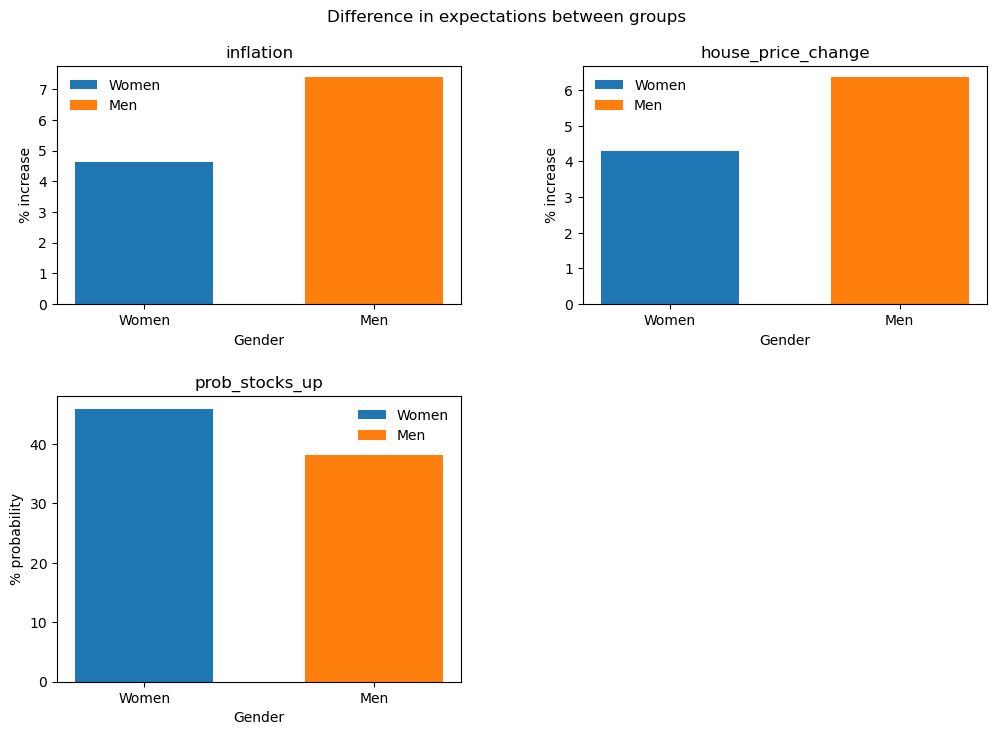

In [597]:
# Making dataframe df1 for gender-specific bar charts, based on different expectation factors
df1 = group_means(df, "female")
# Plotting chart based on dataframe and setting labels
fig, axes = barChart(df1,"female", "Women", "Men", "Gender")

#### Expectation differences between non-college and college graduates for inflation, house price change and stocks


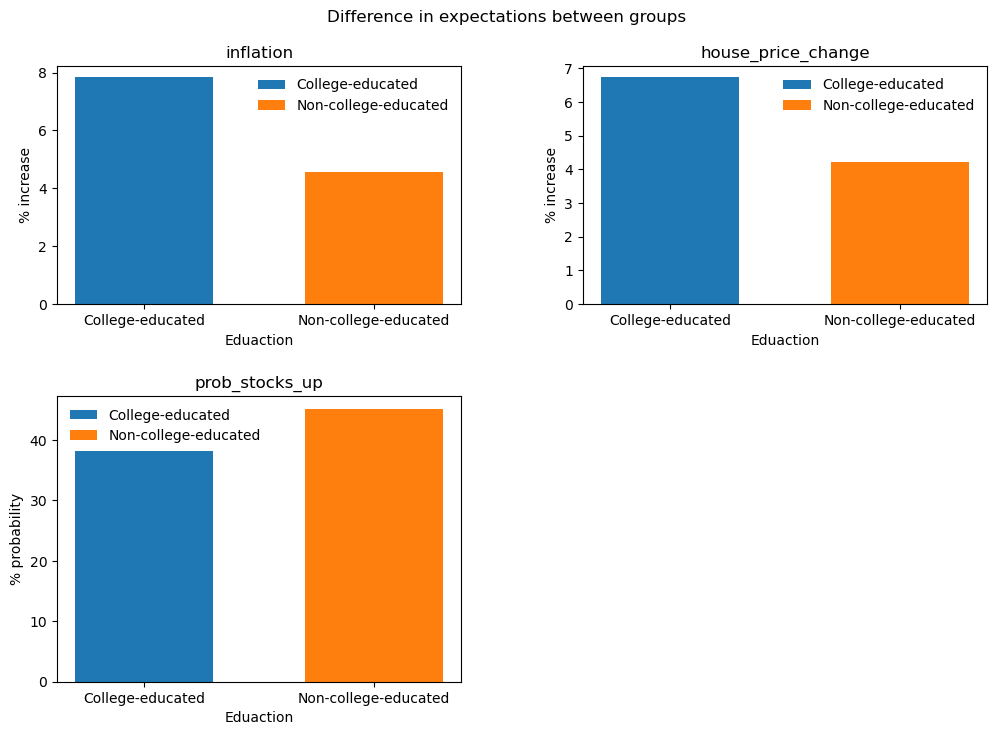

In [598]:
# Making dataframe df2 for education-specific bar charts, based on different expectation factors
df2 = group_means(df, "college")
# Plotting chart based on dataframe and setting labels
fig, axes = barChart(df2, "college", "College-educated", "Non-college-educated", "Eduaction")


#### Expectation differences between low numernacy and high numerancy for inflation, house price change and stocks


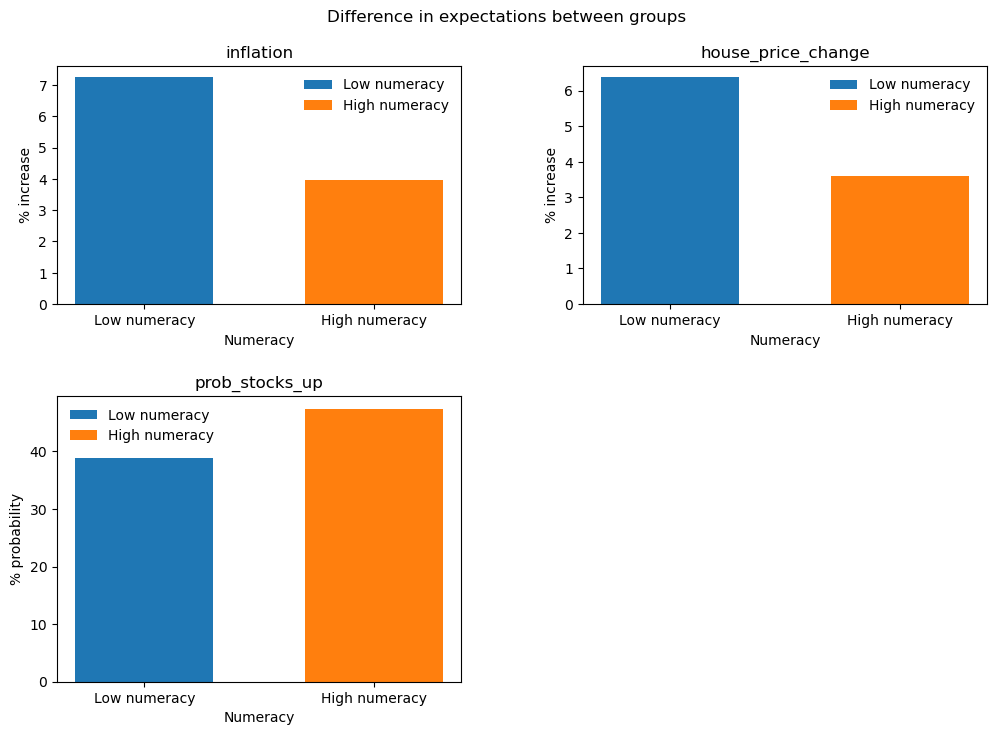

In [599]:
# Making dataframe df3 for numeracy-specific bar charts, based on different expectation factors
df3 = group_means(df, "num_lit_high")
# Plotting chart based on dataframe and setting labels
fig, axes = barChart(df3, "num_lit_high", "Low numeracy", "High numeracy", "Numeracy")

## Part 4 — Expectation dynamics by group




This section examines how expectations about inflation, house prices, and the stock market have evolved over time for different demographic groups.  
Each figure shows monthly averages of expectations between 2015 and 2024, 
with key global and political events marked by dashed vertical lines.  
By comparing men and women, college-educated and non-college respondents, and 
individuals with high versus low numeracy, we can observe how expectations respond 
to major shocks such as the COVID-19 pandemic and the war in Ukraine, and whether 
some groups adjust their beliefs more strongly than others.

### 4.0 - Establish functions to calculate results




#### Function to create monthly averages

In [600]:
# Function to make monthly averages for a chosen group variable
def make_monthly_averages(df, group_col):
    """
    Creates a DataFrame with monthly averages for inflation, house prices, and stock 
    expectations for a given group variable.

    Parameters:
    - df : pandas.DataFrame with the cleaned dataset containing the SCE survey data.
    - group_col : str with the name of the grouping column (e.g. 'female', 'college', or 'num_lit_high').

    Returns:
    - pandas.DataFrame with monthly average expectations for each group, restricted to the period 2015–2024.
    """
    df = df.copy()
    # Ensure we have a date column and that it is datetime format
    if "date" not in df.columns:
        raise KeyError("Expected a 'date' column in the DataFrame.")
    df["date"] = pd.to_datetime(df["date"], errors="coerce")

    # Build a month key
    df["month"] = df["date"].dt.to_period("M").dt.to_timestamp()

    # Remove rows where the date could not be parsed
    df = df.dropna(subset=["month"])

    # Calculate monthly means for each group
    grouped = group_means(df, ["month", group_col])

    # Keep only the period 2015–2024
    grouped = grouped[(grouped["month"] >= "2015-01-01") & (grouped["month"] <= "2024-12-31")]
    return grouped

#### Function to plot expection dynamics


In [601]:
def plot_expectations(grouped, group_col, title_suffix):
    """
    Plots average expectations for each group value in three panels:
    inflation, house-price expectations, and stock-market expectations.

    Parameters:
    - grouped : pandas.DataFrame produced by make_monthly_averages(), containing monthly averages.
    - group_col : str, the column name indicating group membership (e.g. 'female', 'college', 'num_lit_high').
    - title_suffix : str - a descriptive label added to the figure title (e.g. "gender-level" or "education-level").

    Returns:
    - None, it displays a matplotlib figure with three vertically stacked panels.

    """
    # Identify unique group values (e.g. [0, 1])
    groups = sorted(grouped[group_col].unique())

    if group_col == "female":
        legend_labels = {0: "Male", 1: "Female"}
    elif group_col == "college":
        legend_labels = {0: "Non-college", 1: "College"}
    elif group_col == "num_lit_high":
        legend_labels = {0: "Low numeracy", 1: "High numeracy"}
    else:
        # Default: just use the group values themselves
        legend_labels = {g: str(g) for g in groups}

    # Create figure with 3 panels (inflation, house prices, stocks)
    fig, axes = plt.subplots(3, 1, figsize=(9, 7), sharex=True)

    # Add figure title
    fig.suptitle(f"Expectation dynamics by {title_suffix}", x=0.4)

    # Panel 1: Expected inflation 
    for g in groups:
        sub = grouped[grouped[group_col] == g]
        axes[0].plot(sub["month"], sub["inflation"], label=legend_labels.get(g, str(g)))
    axes[0].set_ylabel("Expected inflation (%)")

    # Panel 2: Expected house-price change
    for g in groups:
        sub = grouped[grouped[group_col] == g]
        axes[1].plot(sub["month"], sub["house_price_change"], label=legend_labels.get(g, str(g)))
    axes[1].set_ylabel("Expected house-price change (%)")

    # Panel 3: Probability stocks increase
    for g in groups:
        sub = grouped[grouped[group_col] == g]
        axes[2].plot(sub["month"], sub["prob_stocks_up"], label=legend_labels.get(g, str(g)))
    axes[2].set_ylabel("Prob. stocks up (%)")
    axes[2].set_xlabel("Date")

    # Add event lines + text labels
    for ax in axes:

        ylim = ax.get_ylim() # get y-axis range
        y_pos = ylim[1] * 0.98  # position text near top of plot

        for date, label in events:

            event_date = pd.to_datetime(date)
            ax.axvline(event_date, color="black", linestyle="--", linewidth=0.6) # Vertical dashed line

            # Add event label next to each line
            ax.text(event_date, y_pos, label,
                    rotation=90, va="top", ha="right",
                    fontsize=8, alpha=0.75)
            
        ax.grid(True, alpha=0.3)

    # Place legend outside the right margin 
    axes[0].legend(ncol=1, frameon=False, loc="center left", bbox_to_anchor=(1.02, 0.5))
    fig.tight_layout()
    plt.show()

### 4.1/2/3 - How expectations reacted to important geopolitical events


##### Important events

In [602]:
# Important events to mark in the plots as vertical lines
events = [
    ("2016-11-08", "Trump elected (1st)"),
    ("2020-02-01", "COVID-19 global"),
    ("2020-11-03", "Biden elected"),
    ("2022-02-24", "Ukraine war"),
    ("2023-10-03", "Jon Fosse Nobel"),
    ("2024-11-05", "Trump elected (2nd)"),
]

#### Expectation dynamics by gender 

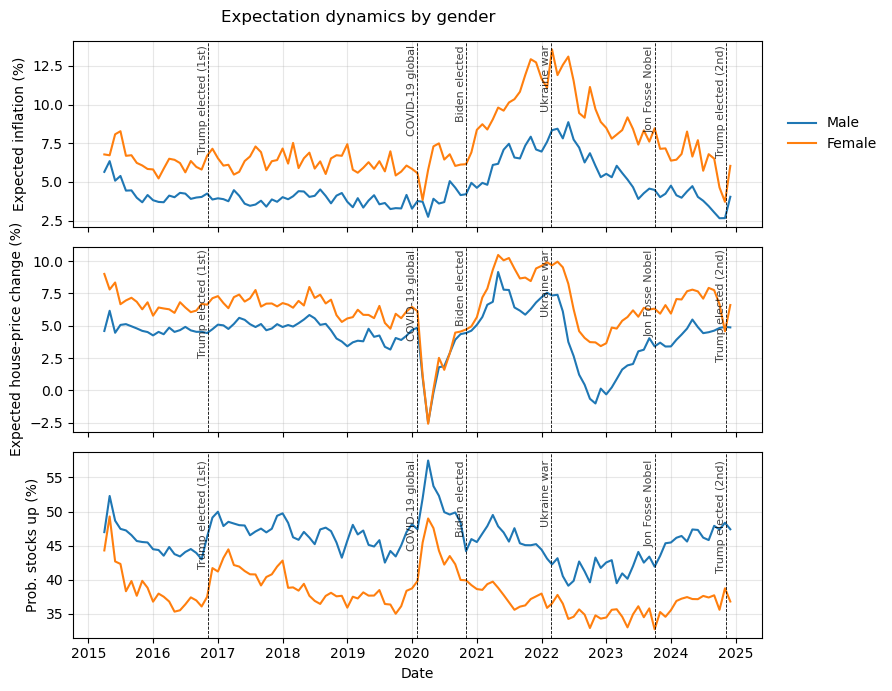

In [603]:
# (a) Gender
gender_data = make_monthly_averages(df, "female")
plot_expectations(gender_data, "female", "gender")


#### Expectation dynamics by Education

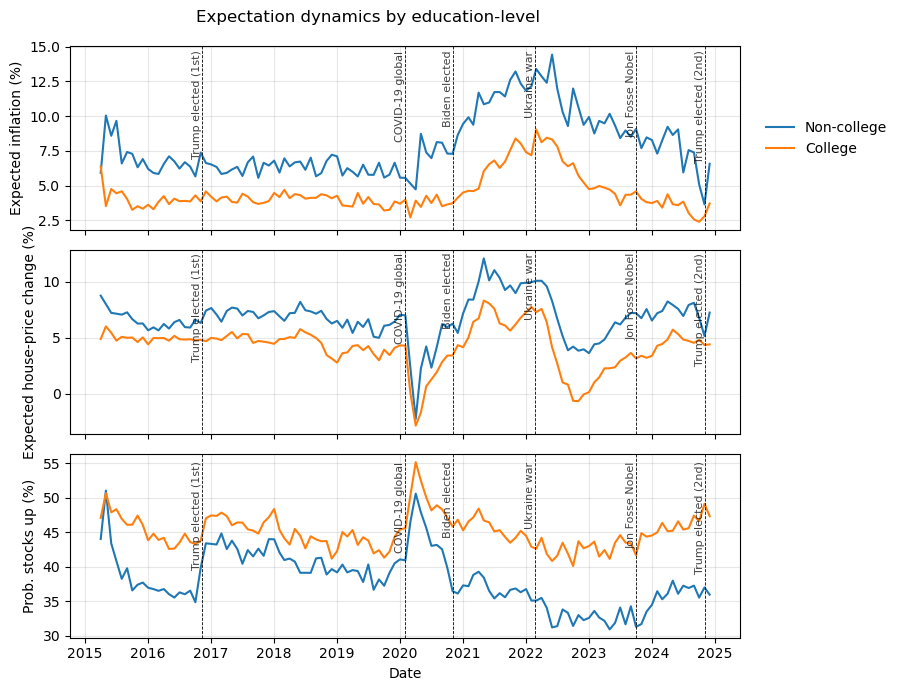

In [ ]:

college_data = make_monthly_averages(df, "college")
plot_expectations(college_data, "college", "education-level")

#### Expectation dynamics by numeracy level

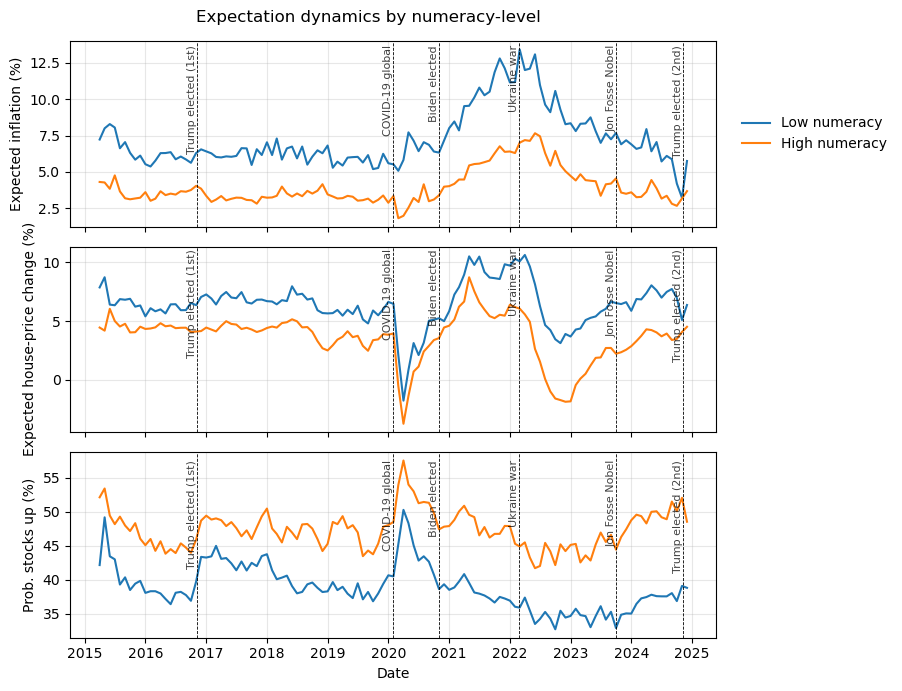

In [ ]:
numeracy_data = make_monthly_averages(df, "num_lit_high")
plot_expectations(numeracy_data, "num_lit_high", "numeracy-level")

#### Conclusion from graphs 

Across all groups, the COVID-19 pandemic and Russia’s invasion of Ukraine stand out as the events that most strongly influenced household expectations. Both episodes produced clear spikes in expected inflation and temporary declines in stock-market optimism, while the pandemic also led to a brief drop in expected house-price growth.

Differences across groups are systematic rather than random. Women, less-educated, and lower-numeracy respondents adjusted their expectations more sharply to these shocks, showing larger swings and slower normalization. In contrast, college-educated and high-numeracy individuals exhibited smaller, more gradual reactions, consistent with better-anchored and more forward-looking expectations. Political transitions such as the 2016 and 2020 U.S. elections caused smaller, short-term changes, while cultural events had negligible impact.


## Part 5 — Correlation between realized and expected inflation

### 5.0 - Establish functions to investige correlation

#### Function to calculate inflation

In [606]:
def inflation(cpi_idx, months, forward=True):
    """
    Calculate inflation rate based on CPI index.

    Parameters:
    - cpi_idx (pd.DataFrame): DataFrame containing CPI index with a column named "CPI".
    - months (int): Number of months over which to calculate inflation. Default is 12.
    - forward (bool): If True, calculate forward-looking inflation; else, backward-looking. Default is True.

    Returns:
    - pd.Series: Inflation rates as percentages.
    """

    cpi = cpi_idx["CPI"]

    if forward:
        # Future inflation: compare today to future CPI
        return (cpi.shift(-months) - cpi) / cpi * 100
    else:
        # Historical inflation: compare today to past CPI
        return (cpi - cpi.shift(months)) / cpi.shift(months) * 100


#### Function to create a DataFrame combining expected inflation by group with backward- and forward-looking inflation


In [607]:
def compute_merge_inflation(cpi_data, infl_gender):
    '''
    Merges inflation data with gendered expected inflation

    Parameters:
    - cpi_data: DataFrame with CPI data
    - infl_gender: DataFrame with gendered expected inflation data

    Returns:
    - Merged DataFrame with expected and future and past realized inflation
    '''
    
    # Make a copy of cpi_data, cpi_idx to avoid modifying the original DataFrame
    # Prepare CPI series with datetime monthly index
    cpi_idx = cpi_data.copy()
    cpi_idx["DATE"] = pd.to_datetime(cpi_idx["DATE"])
    cpi_idx = cpi_idx.set_index("DATE").sort_index()
    cpi_idx.index = cpi_idx.index.to_period("M").to_timestamp()

    # Forward-looking and backward-looking 12-month inflation
    cpi_idx["inflation_forward_12m"] = inflation(cpi_idx, months=12)
    cpi_idx["inflation_backward_12m"] = inflation(cpi_idx, months=12, forward=False)

    # Restrict to the analysis window, and only relevant data to prepare for merge
    cpi_fw = cpi_idx.loc["2015-01":"2024-12", ["inflation_forward_12m", "inflation_backward_12m"]].copy()

    # Rename gender columns for clarity and merge
    merged = infl_gender.rename(columns={0.0: "exp_infl_male", 1.0: "exp_infl_female"})
    return merged.join(cpi_fw, how="inner")




#### Function to visualize the correlation between gendered inflation expectations and forward/backward-looking inflation


In [608]:
def plot_inflation_correlation(cpi_df, inflation_type="forward"):
    """
    Creates scatter plots comparing expected vs forward- or 
    backward-looking realized inflation by gender.
    
    Parameters:
    - cpi_df: DataFrame containing expected and realized inflation data
    - inflation_type: 'forward' or 'backward' to select inflation measure
    
    Returns:
    - figure and axes objects
    """

    # Determine the correct inflation column and labels
    inflation_col = f"inflation_{inflation_type}_12m"
    if inflation_type == "forward":
        time_label = "Future"
    else:
        time_label = "Past"

    # Create two subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

    # Plot for each gender with x equal to gender specific expected inflation and y equal to realized inflation
    for i, gender in enumerate(["male", "female"]):
        ax = axes[i]
        x = cpi_df[f"exp_infl_{gender}"]
        y = cpi_df[inflation_col]
        
        # Fit and plot trend line
        valid = x.notna() & y.notna()
        if valid.sum() > 1:  # need at least two points
            coeffs = np.polyfit(x = x[valid], 
                                y = y[valid], 
                                deg = 1)
            line_x = np.linspace(start = x.min(), 
                                 stop = x.max(), 
                                 num = 100)
            line_y = np.polyval(p= coeffs, 
                                x= line_x)
            ax.plot(line_x, 
                    line_y, 
                    color="red", 
                    lw=2, 
                    label="Trend line")

        # Making scatter plot and set titles and labels
        ax.scatter(x, y)
        ax.set(title=f"{gender.capitalize()} - Expected vs {time_label} 12-month Inflation", 
               xlabel="Expected Inflation", 
               ylabel=f"{time_label} 12-month Inflation")

        # Adding correlation coefficient
        corr = x.corr(y)
        ax.text(0.05, 0.95, f"Corr: {corr:.2f}", 
                transform=ax.transAxes, 
                fontsize=12, 
                verticalalignment="top")

    plt.tight_layout()
    return fig, axes

### 5.1.1 Calculating necessary variables to show scatter plots

In [609]:
# build gendered expected inflation table: index=month, columns=0.0 (male) and 1.0 (female)
infl_f = gender_data.pivot(index="month", columns="female", values="inflation").sort_index()
   
# Store merged DataFrame based on CPI and gendered expected inflation
cpi_gender = compute_merge_inflation(cpi, infl_f)

### 5.1.2/3 - Plotting a figure showing the correlation between expected inflation and forward-looking realized inflation, based on gender specific data

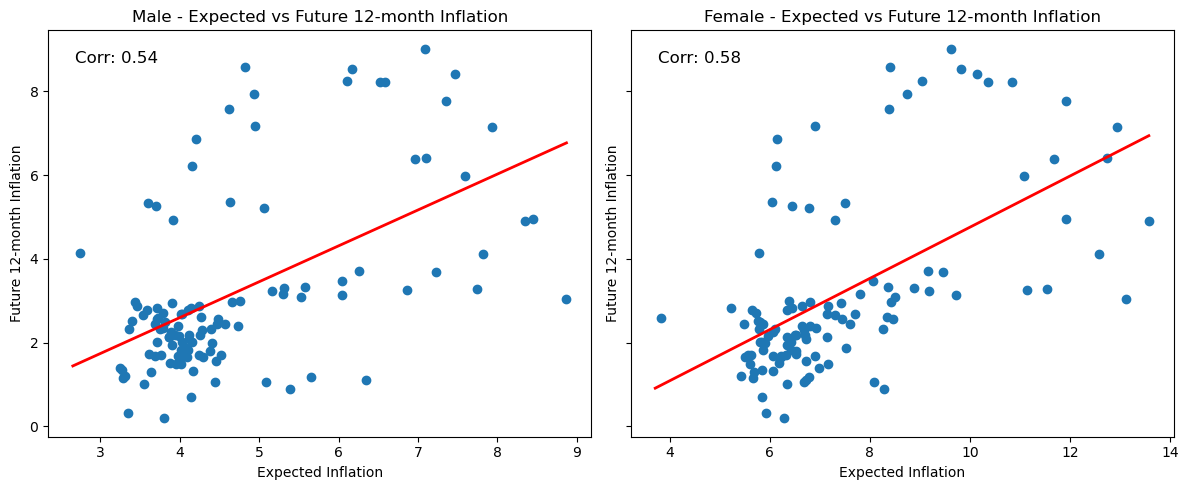

In [610]:
# Plotting for forward-looking inflation
fig, axes = plot_inflation_correlation(cpi_gender, inflation_type="forward")

### 5.2 - Plotting a figure showing the correlation between expected inflation and backward-looking realized inflation, based on gender specific data

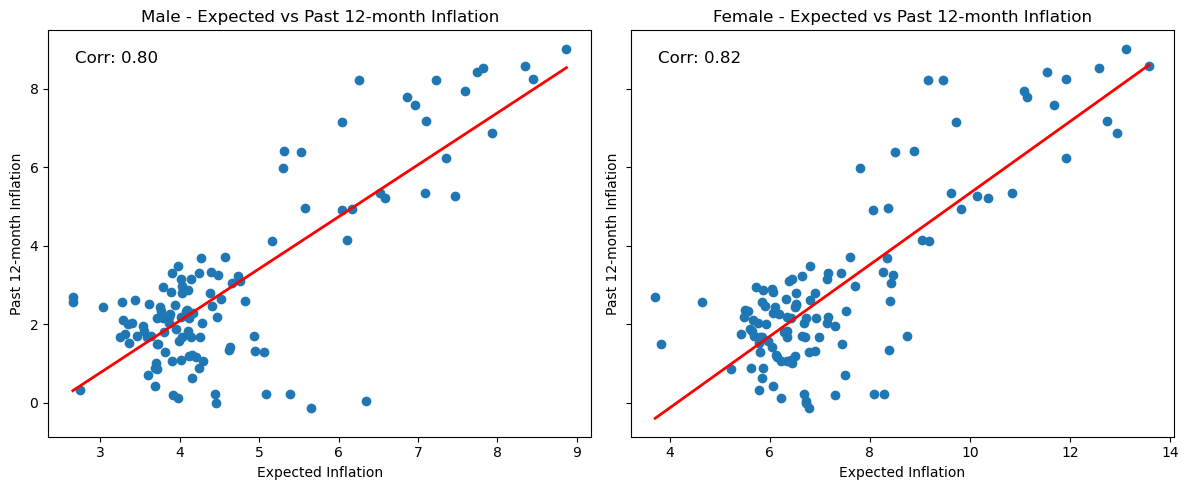

In [611]:
# Plotting for backward-looking inflation
fig, axes = plot_inflation_correlation(cpi_gender, inflation_type="backward")

### Significance of the correlation showed in the scatter plots


These two graphs show a significant difference in the correlation between expected inflation and future vs past inflation. The correlation between future and expected inflation is weak, with an average correlation coefficient of 0.56, especially compared to expected vs past inflation with an average of 0.81. This shows that peoples expected inflation rate is highly influenced by the past inflation, and an educated guess for the future inflation is hard to get right. 
Despite this we also see a small difference in the correlation coefficient between men and women in both the future and past 12-month inflation, where women in both instances have a higher correlation coefficient. This means women therefore are better at guessing future inflation, but also lean somewhat more on past inflation when making their guess. 

## Sources: 
- Generative AI: used for identifying bugs and suggested correction